<h2>Monte Carlo method with control variate technique for arithmetic Asian
call/put options</h2>

In [1]:
import numpy as np
import math
from scipy.stats import norm
from numpy.random import default_rng

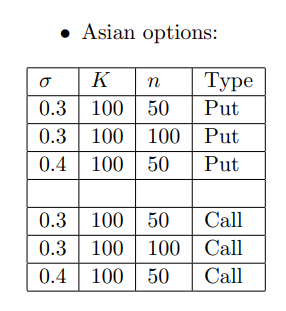

In [136]:
class AsianOptionCal:
    def __init__(self,sigma,N,S,K,T,r,M,option):
        self.sigma = sigma
        self.N = N
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.M = M
        self.option = option
        self.sigmahat = sigma * math.sqrt((N+1)*(2*N+1)/(6*N*N))
        self.muhat = (r-0.5*sigma*sigma) * (N+1)/(2*N) + 0.5 * self.sigmahat * self.sigmahat
        self.d1hat = (math.log(S/K) + (self.muhat + 0.5*self.sigmahat*self.sigmahat)*T ) / (self.sigmahat *math.sqrt(T))
        self.d2hat = self.d1hat - self.sigmahat * math.sqrt(T)
        self.discount = np.exp(-r*T)
    def arithmeticMath(self,s):
        return np.mean(s)

    def geometricMath(self,s):
        return np.exp(np.mean(np.log(s)))
    
    def geometricClosedForm(self):
        if self.option == "Call":
            callV = np.exp(-self.r*self.T) * (self.S*np.exp(self.muhat*self.T)*norm.cdf(self.d1hat) - self.K*norm.cdf(self.d2hat))
            return callV
        if self.option == "Put":
            putV = np.exp(-self.r*self.T) * (self.K*norm.cdf(-self.d2hat) - self.S*np.exp(self.muhat*self.T)*norm.cdf(-self.d1hat))
            return putV
    
    def randomPriceSample(self):
        Z = np.random.standard_normal(1)
        growFactor = np.exp((self.r-0.5*self.sigma*self.sigma)*self.T/self.N) * np.exp(self.sigma * math.sqrt(self.T/self.N) * Z)
        spathArray=[self.S*growFactor]
        for i in range(1,self.N): # checkbug
            Z = np.random.standard_normal(1)
            growFactor = np.exp((self.r-0.5*self.sigma*self.sigma)*self.T/self.N) * np.exp(self.sigma * math.sqrt(self.T/self.N) * Z)
            newPrice = spathArray[i-1] * growFactor
            spathArray.append(newPrice)     
        return spathArray
    
    def arithmetricPayoff(self):
        np.random.seed(3)
        arithPayoffArray = []
        for i in range(self.M):
            spathArray = self.randomPriceSample()
            spathMean = self.arithmeticMath(spathArray)
            arithPayoffArray.append(max(spathMean - self.K, 0))
            
        return arithPayoffArray
    
    def geometricPayoff(self):
        np.random.seed(3)
        geoPayoffArray = []
        for i in range(self.M):
            spathArray = self.randomPriceSample()
            spathMean = self.geometricMath(spathArray)
            geoPayoffArray.append(max(spathMean - self.K, 0))
        return geoPayoffArray
    
    def arithmetricStandardMC(self):
        arithPayoffArray = self.arithmetricPayoff()
        vArith = self.discount * self.arithmeticMath(arithPayoffArray)
        return vArith
    
    def geometricStandardMC(self):
        geoPayoffArray = self.geometricPayoff()
        vGeo = self.discount * self.arithmeticMath(geoPayoffArray)
        return vGeo
    
    def arithmetricStandardMCWithCV(self):
        arithPayoffArray = self.arithmetricPayoff()
        geoPayoffArray = self.geometricPayoff()
        vArith = self.discount * self.arithmeticMath(arithPayoffArray)
        VCgeo = self.geometricClosedForm()
        VGeo = self.geometricStandardMC()
        covXY = np.cov(arithPayoffArray,geoPayoffArray)[0][1]
        theta = covXY/np.var(geoPayoffArray)
        return vArith + theta * (VCgeo - VGeo)
    

In [137]:
model = AsianOptionCal(sigma=0.3,N=50,S=100,K=100,T=3,r=0.05,M=100000,option="Call")

In [138]:
model.geometricClosedForm()

13.25912613053641

In [139]:
model.geometricStandardMC()

13.294876312828912

In [140]:
model.arithmetricStandardMC()

14.773352881252862

In [141]:
model.arithmetricStandardMCWithCV()

14.733812354402918

In [101]:
np.random.seed(3)
np.random.standard_normal(1)

array([1.78862847])

In [102]:
np.random.standard_normal(1)

array([0.43650985])

In [103]:
np.random.standard_normal(1)

array([0.09649747])

In [104]:
np.random.standard_normal(1)

array([-1.8634927])